In [1]:
import numpy as np
import torch
import math
from matplotlib import pyplot as plt

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 20,
})

In [3]:
# I adapted this implementation from GPytorch library
# https://github.com/cornellius-gp/gpytorch/blob/master/gpytorch/kernels/matern_kernel.py

def matern_kernel(x1, x2, length_scale, nu=1.5, eps=1e-6):
    # Ensure lengthscale is positive to avoid division by zero
    lengthscale = torch.clamp(length_scale, min=eps)

    # Mean subtraction (for input normalization)
    mean_x1 = x1.mean(dim=-2, keepdim=True)
    x1_ = (x1 - mean_x1).div(lengthscale)
    x2_ = (x2 - mean_x1).div(lengthscale)

    # Distance computation
    distance = torch.cdist(x1_, x2_, p=2)

    # Matern kernel computation
    exp_component = torch.exp(-math.sqrt(nu * 2) * distance)

    if nu == 0.5:
        constant_component = 1
    elif nu == 1.5:
        constant_component = (math.sqrt(3) * distance).add(1)
    elif nu == 2.5:
        constant_component = (math.sqrt(5) * distance).add(1).add(5.0 / 3.0 * distance**2)
    return constant_component * exp_component

def rbf_kernel(x1, x2, length_scale):
    # The un-squeeze operation is adjusted to work with 1D input tensors
    x1 = x1.view(-1, 1) if x1.ndimension() == 1 else x1
    x2 = x2.view(-1, 1) if x2.ndimension() == 1 else x2
    dist_matrix = torch.cdist(x1, x2, p=2)

    return torch.exp(-0.5 * (dist_matrix / length_scale) ** 2)


In [4]:
# GpyTorch library adds jitter in Cholesky implementaiton

def cholesky_with_jitter(K, initial_jitter=1e-8, jitter_max=1e-6, jitter_factor=10):
    jitter = initial_jitter
    jitter_prev = 0
    K_prime = K.clone()

    for i in range(int(math.log10(jitter_max / initial_jitter)) + 1):
        try:
            L, info = torch.linalg.cholesky_ex(K_prime)
            if not torch.any(info):
                return L

            # Handling specific failure cases
            if torch.isnan(K).any():
                raise RuntimeError("NaN values found in the input matrix.")

            # Add jitter only where the Cholesky decomposition failed
            jitter_new = jitter * (jitter_factor ** i)
            diag_add = ((info > 0) * (jitter_new - jitter_prev)).unsqueeze(-1).expand(K.shape)
            K_prime.diagonal(dim1=-1, dim2=-2).add_(diag_add)
            jitter_prev = jitter_new

        except RuntimeError as e:
            if 'not positive definite' not in str(e):
                raise  # Re-raise if the error is not due to positive definiteness

    raise RuntimeError(f"Cholesky decomposition failed. Max jitter tried: {jitter_new}")

In [5]:
class GaussianProcessRegressor(torch.nn.Module):
    def __init__(self, kernel, noise_var, length_scale):
        super(GaussianProcessRegressor, self).__init__()
        self.kernel = kernel
        self.length_scale = torch.nn.Parameter(torch.tensor([length_scale], dtype=torch.float64))
        self.noise_var = torch.nn.Parameter(torch.tensor([noise_var], dtype=torch.float64))

    def forward(self, X_train, Y_train, X_test, use_cholesky=False):
        
        # print('Lengthscale: ',self.length_scale)
        # print('Noise var: ',self.noise_var)
        
        K = self.kernel(X_train, X_train, self.length_scale)
        K = K + torch.exp(self.noise_var) * torch.eye(X_train.size(0), dtype=torch.float64)
        K_s = self.kernel(X_train, X_test, self.length_scale)
        K_ss = self.kernel(X_test, X_test, self.length_scale)

        if use_cholesky:
            # Using Cholesky decomposition for numerical stability - Algorithm 2.1 from Rasmussen
            L = cholesky_with_jitter(K)
            L_inv = torch.linalg.inv(L)
            
            alpha = L_inv.t().matmul(L_inv).matmul(Y_train)

            # Compute the mean of the test points
            mu_s = K_s.t().matmul(alpha)

            # Compute the covariance of the test points
            v = L_inv.matmul(K_s)
            cov_s = K_ss - v.t().matmul(v)

        else:
            # Rasmussen Book
            K_inv = torch.inverse(K)
            alpha = K_inv.matmul(Y_train)
            
            # Compute the mean of the test points
            mu_s = K_s.t().matmul(alpha) # Eq 2.25
            
            # Compute the covariance of the test points
            v = K_inv.matmul(K_s) # Eq 2.26
            cov_s = K_ss - K_s.t().matmul(v) 

        return mu_s, cov_s

    def log_marginal_likelihood(self, X_train, Y_train, use_cholesky=False):
        K = self.kernel(X_train, X_train, self.length_scale)
        K = K + torch.exp(self.noise_var) * torch.eye(X_train.size(0), dtype=torch.float64)

        if use_cholesky: # use Cholesky - Algorithm 2.1 from Rasmussen
            
            L = cholesky_with_jitter(K)
            # Ensure Y_train is a column vector
            if Y_train.ndim == 1:
                Y_train = Y_train.unsqueeze(-1)

            # Compute the log marginal likelihood
            L_inv = torch.linalg.inv(L)

            alpha = L_inv.t().matmul(L_inv).matmul(Y_train)
            
            mll = -0.5 * Y_train.t().matmul(alpha)
            mll -= torch.sum(torch.log(torch.diagonal(L)))
            mll -= 0.5 * X_train.size(0) * torch.log(torch.tensor(2 * math.pi, dtype=torch.float64))

        else: # use direct inverse
            
            K_inv = torch.inverse(K)
            alpha = K_inv.matmul(Y_train)

            # Compute the log marginal likelihood from Eq 2.30
            mll = (-0.5 * Y_train.t().matmul(alpha)
                   - 0.5 * torch.log(torch.linalg.det(K))
                   - 0.5 * X_train.size(0) * torch.log(torch.tensor(2 * math.pi, dtype=torch.float64)))

        return mll.squeeze()

In [6]:
# Optimizer:
def optimize_hyperparameters(gp, X_train, Y_train, lr, epochs):

    optimizer = torch.optim.Adam(gp.parameters(), lr=lr)
    l = []
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        
        mll = gp.log_marginal_likelihood(X_train, Y_train)
        loss = -mll
        loss_normalized = loss/Y_train.shape[0]  # Normalize the loss - GPyTorch uses the mean loss across all data points
        l+= [loss_normalized.item()]
        loss_normalized.backward()
        optimizer.step()
        
        print('\n******* Iteration {} *******'.format(epoch+1))
        
        for name, param in gp.named_parameters():
            print(f'Parameter name: {name}, Value: {param.data}')
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss_normalized.item()}')
        
    # Set lengthscale to the optimized value from library 
    # gp.length_scale = torch.nn.Parameter(torch.tensor([2.424041986465454], dtype=torch.float64))
    
    # Set noise to the optimized value from library 
    # gp.noise_var = torch.nn.Parameter(torch.tensor([-3.7276058197021484], dtype=torch.float64))

    print('Optimization complete!')
    plt.plot(l)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [7]:
# Plot the results

def plot_test_results(X,Y,X_t,mu_s_plot,variance_plot):

    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y, c='red', label='Training data')
    plt.plot(X_t, mu_s_plot, 'b', label='GP mean')

    plt.fill_between(X_t.flatten(), mu_s_plot - 1.96 * np.sqrt(variance_plot),
                     mu_s_plot + 1.96 * np.sqrt(variance_plot), color='blue', alpha=0.2)  # 95% confidence interval
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def standardize_and_convert_to_tensor(data, scaler_type, scaler=None):
    # Check if the data is 1D, and reshape it to (-1, 1) for a single feature
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    # No need to reshape if data is already 2D

    if scaler is None:
        if scaler_type == 'standard':
            scaler = StandardScaler()
        elif scaler_type == 'minmax':
            scaler = MinMaxScaler(feature_range=(0.01, 1))
        data_scaled = scaler.fit_transform(data)
    else:
        data_scaled = scaler.transform(data)

    # Convert the scaled data to a double precision tensor and return
    return torch.tensor(data_scaled, dtype=torch.float64), scaler


# Prepare the data
def data_preprocess(X, Y, X_t, scaling, scaler_type):
    if scaling:
        # Convert numpy arrays to torch tensors and then standardize the data

        # Apply the standardization and conversion to both the training inputs and outputs
        X_train, scaler_X = standardize_and_convert_to_tensor(X, scaler_type)
        Y_train, scaler_y = standardize_and_convert_to_tensor(Y, scaler_type)

        # Reshape Y_train_tensor to be a 2D tensor for compatibility with PyTorch
        Y_train = Y_train.view(-1, 1)

        X_test = scaler_X.transform(X_t)  # Standardize the test points
        X_test = torch.from_numpy(X_test).double()

        return X_train, Y_train, X_test, scaler_X, scaler_y

    else:
        X_train = torch.from_numpy(X).double().view(-1, 1)
        Y_train = torch.from_numpy(Y).double().view(-1, 1)
        X_test = X_t

        return X_train, Y_train, X_test, None, None


def data_postprocess(mu_s, variance, variance_aleo, variance_eps, scaler_y, Y, Y_train, scaling_type, scaling=True):
    if scaling:
        if scaling_type == 'standard':
            # Inverse scaling for the GP mean predictions
            mu_s_plot = scaler_y.inverse_transform(mu_s.reshape(-1, 1)).flatten()
            #
            variance_plot = scaler_y.var_ * variance.flatten()
            variance_aleo_plot = scaler_y.var_ * variance_aleo.flatten()
            variance_eps_plot = scaler_y.var_ * variance_eps.flatten()

        elif scaling_type == 'minmax':
            # Inverse scaling for the GP mean predictions
            mu_s_plot = scaler_y.inverse_transform(mu_s.reshape(-1, 1)).flatten()
            variance_plot = (variance * Y.var() / Y_train.var()).numpy().flatten()
            variance_aleo_plot = (variance_aleo * Y.var() / Y_train.var()).numpy().flatten()
            variance_eps_plot = (variance_eps * Y.var() / Y_train.var()).numpy().flatten()

    else:
        mu_s_plot = mu_s
        variance_plot = variance
        variance_aleo_plot = variance_aleo
        variance_eps_plot = variance_eps

    return mu_s_plot, variance_plot, variance_aleo_plot, variance_eps_plot

In [9]:
# X = torch.tensor([-4.3, -4.6, -4.8, -3.1, -1.4, -5.6, -6.8, -4.1, -0.5, -2.4, -4.9, -3.6, -8.2, -5.9, -4.0,
#                   -8.5, -8.6, -0.6, -7.0, -7.4, -2.6, -2.9, -9.7, -2.2, -8.1, -1.9, -5.3, -6.7, -8.0, -0.4,
#                   -3.5, -5.8, -2.3, -1.5, -9.8, 10.0, 10.2, 10.1, 10.6, 9.5, -6.8, -7.0, -6.8, -6.9, -6.8],
#                  dtype=torch.float64).reshape((-1, 1))
# 
# Y = torch.tensor([-0.6, 0.0, 0.2, -1.8, -1.7, 1.3, 1.8, -0.6, -0.6, -2.2, 0.3, -1.2, 1.5, 1.5, -1.1, 1.1, 1.4,
#                   -0.7, 2.1, 1.8, -1.8, -1.9, -0.1, -2.1, 1.6, -1.9, 0.5, 1.5, 1.3, -0.7, -1.3, 1.6, -2.2, -1.6,
#                   -0.3, 0.7, 1.1, 0.9, 1.0, 0.6, 2.0, 1.9, 1.9, 2.1, 1.9],
#                  dtype=torch.float64).reshape((-1, 1))

x_train = np.load("/Users/ozgeozbayram/Desktop/GP_heteroscedastic/X_train.npy")
y_train = np.load("/Users/ozgeozbayram/Desktop/GP_heteroscedastic/Y_train.npy")

# X = torch.from_numpy(x_train).double()
# Y = torch.from_numpy(y_train).double().squeeze(-1)

X_t1 = torch.linspace(float(min(x_train).item()), float(max(x_train).item()), 500, dtype=torch.float64).unsqueeze(-1)

X, Y, X_t, scaler_X, scaler_y = data_preprocess(x_train, y_train, X_t1, scaling=True, scaler_type='minmax')

In [10]:
kern = matern_kernel
# kern = rbf_kernel

num_ites = 1000
learning_rate = 0.1 # same as the GpyTorch library

initial_noise = -1e-1
length_scale = 1e-1


******* Iteration 1 *******
Parameter name: length_scale, Value: tensor([0.2000], dtype=torch.float64)
Parameter name: noise_var, Value: tensor([-0.2000], dtype=torch.float64)
Epoch 1/1000, Loss: 1.001733459731238

******* Iteration 2 *******
Parameter name: length_scale, Value: tensor([0.2891], dtype=torch.float64)
Parameter name: noise_var, Value: tensor([-0.3001], dtype=torch.float64)
Epoch 2/1000, Loss: 0.9211597070693945

******* Iteration 3 *******
Parameter name: length_scale, Value: tensor([0.3697], dtype=torch.float64)
Parameter name: noise_var, Value: tensor([-0.4002], dtype=torch.float64)
Epoch 3/1000, Loss: 0.8598643774361839

******* Iteration 4 *******
Parameter name: length_scale, Value: tensor([0.4435], dtype=torch.float64)
Parameter name: noise_var, Value: tensor([-0.5004], dtype=torch.float64)
Epoch 4/1000, Loss: 0.8044242893046976

******* Iteration 5 *******
Parameter name: length_scale, Value: tensor([0.5116], dtype=torch.float64)
Parameter name: noise_var, Value:

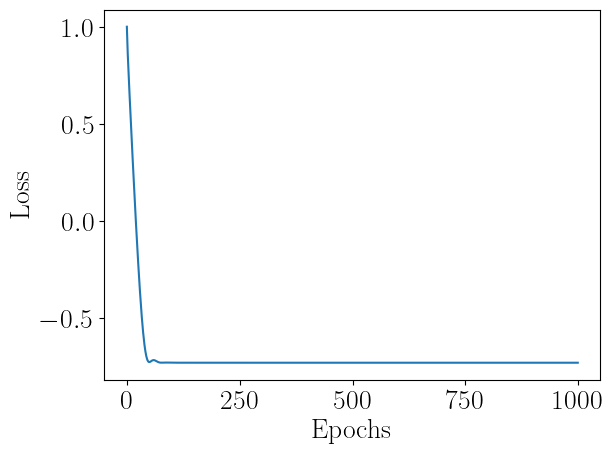

In [11]:
# Initialize the GP model with the new settings for float64 precision
gp = GaussianProcessRegressor(kernel=kern, noise_var=initial_noise, length_scale=length_scale)

# Run the optimization with the new settings
optimize_hyperparameters(gp, X, Y, lr=learning_rate, epochs=num_ites)

# Output the final length_scale and variance parameters after optimization
length_scale_optimized = gp.length_scale.item()
noise_var_optimized = gp.noise_var.item()


# Return the optimized hyperparameters
length_scale_optimized, noise_var_optimized

with torch.no_grad():
    mu_s, cov_s = gp(X, Y, X_t)

In [12]:
# Convert predictions to numpy for plotting purposes
mu_s = mu_s.numpy().flatten()
cov_s = cov_s.numpy()

# add the *constant* noise to the variance following the GPyTorch library
# https://docs.gpytorch.ai/en/latest/_modules/gpytorch/likelihoods/gaussian_likelihood.html
variance = cov_s.diagonal() 
# variance = cov_s.diagonal() + np.exp(gp.noise_var.item())

In [13]:
mu_s1, variance1, variance1, variance1 = data_postprocess(mu_s, variance, variance, variance, scaler_y, y_train, Y, 'minmax', scaling=True)


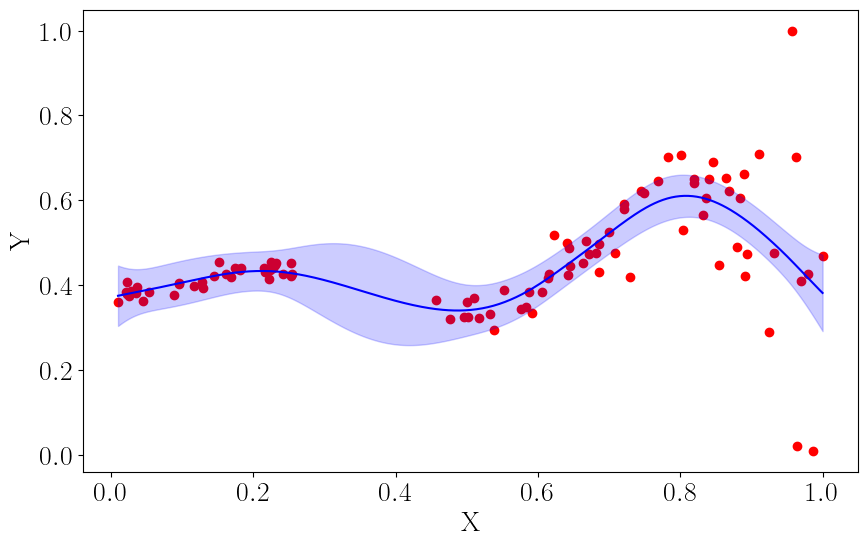

Kernel parameters: lenghtscale = 1.1629567862931733, noise_var= -4.564975241151784, exp_noise_var= 0.010410136946568956


In [14]:
plot_test_results(X,Y,X_t,mu_s,variance)

print(f"Kernel parameters: lenghtscale = {length_scale_optimized}, noise_var= {noise_var_optimized}, exp_noise_var= {np.exp(noise_var_optimized)}")